In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_confusion_matrix
import time

# 1- Import data and preprocessing

In [ ]:
train = pd.read_csv('./emnist-balanced-train.csv')
test = pd.read_csv('./emnist-balanced-test.csv')

In [ ]:
train.head(5)

,45,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.524,0.525,0.526,0.527,0.528,0.529,0.530,0.531,0.532,0.533
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Change number to string

In [ ]:
by_merge_map = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A', 11:'B',
                12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K', 21:'L', 22:'M',
                23:'N', 24:'O', 25:'P', 26:'Q', 27:'R', 28:'S', 29:'T', 30:'U', 31:'V', 32:'W', 33:'X',
                34:'Y', 35:'Z', 36:'a', 37:'b', 38:'d', 39:'e', 40:'f', 41:'g', 42:'h', 43:'n', 44:'q',
                45:'r', 46:'t'}

## Clean D.S

In [ ]:
columns = ['labels']
for i in range(train.shape[1]-1):
    columns.append(i)

train.columns = columns
test.columns = columns

train.head()

,labels,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
classes = train['labels'].unique()
print('number of classes: ', len(classes))

number of classes:  47


#2- Train Test Split

In [ ]:
X=train.loc[:,train.columns != 'labels']
y=train['labels']

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  train_size=0.8,
                                                  test_size=0.2,
                                                  random_state=42)

In [ ]:
x_train = x_train / 255.0
x_val = x_val / 255.0

In [ ]:
testX = test.values[:, 1:]
x_test = testX / 255.0
y_test = test['labels'].values

In [ ]:
print('trianing set: ', x_train.shape, y_train.shape)
print('validation set: ', x_val.shape, y_val.shape)
print('test set: ', x_test.shape, y_test.shape)

trianing set:  (90239, 784) (90239,)
validation set:  (22560, 784) (22560,)
test set:  (18799, 784) (18799,)


#3- Show random image

In [ ]:
train_samples=random.sample(range(0, len(x_train)), 9)
test_samples = random.sample(range(0, len(x_val)), 9)

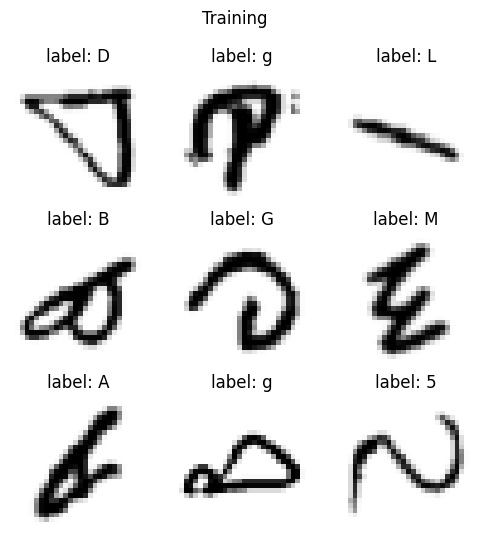

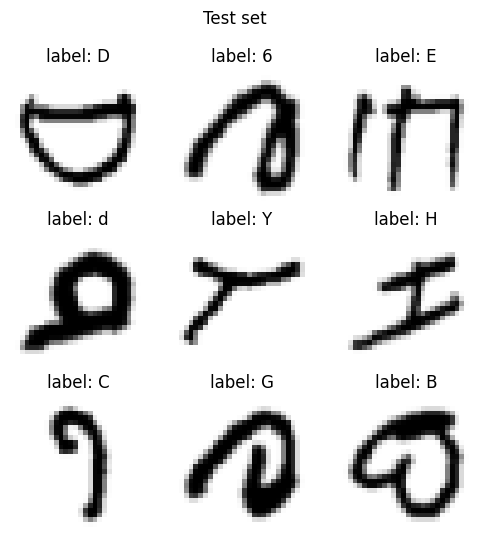

In [ ]:
plt.figure(figsize=(6,6))
plt.suptitle('Training')

for i in train_samples:
  plt.subplot(3,3,train_samples.index(i)+1)
  plt.imshow(x_train.iloc[i,:].values.reshape(28,28), cmap='binary')
  plt.title(f'label: {by_merge_map[y_train.iloc[i]]}')
  plt.axis('off')


plt.figure(figsize=(6, 6))
plt.suptitle('Test set')
for i in test_samples:
    plt.subplot(3, 3, test_samples.index(i)+1)
    plt.imshow(x_val.iloc[i,:].values.reshape(28,28), cmap='binary')
    plt.title(f'label: {by_merge_map[y_val.iloc[i]]}')
    plt.axis('off')

#4- Build CNN model and train model

In [ ]:
desired_accuracy = 0.92

# create callback to stop training when we reached desired accuracy
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') is not None and logs.get('accuracy') >= desired_accuracy):
            print('\nReached 92% training accuracy: cancelling training...')
            self.model.stop_training = True

# instantiate callback
callbacks = myCallback()

In [ ]:
def train_model():
    # define model
    model = tf.keras.models.Sequential([
        # initial normalization
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),

        # first convolution
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu'), # applies kernels to our data
        tf.keras.layers.MaxPooling2D(2, 2), # reduce dimension

        # second convolution
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # third convolution
        tf.keras.layers.Conv2D(24, (3, 3), activation='relu'),

        # feed to DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),

        tf.keras.layers.Dense(len(classes), activation=tf.nn.softmax) # generalized logistic regression
    ])

    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model = train_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 24)          3

In [ ]:
history = model.fit(x_train, y_train, epochs=1000,
                    validation_data=(x_val, y_val),
                    batch_size=4096, verbose=1,callbacks=[callbacks])

Epoch 1/1000
23/23 [==============================] - 34s 1s/step - loss: 3.7443 - accuracy: 0.0876 - val_loss: 3.4158 - val_accuracy: 0.1738
Epoch 2/1000
23/23 [==============================] - 33s 1s/step - loss: 2.7538 - accuracy: 0.3233 - val_loss: 2.0722 - val_accuracy: 0.4316
Epoch 3/1000
23/23 [==============================] - 30s 1s/step - loss: 1.8474 - accuracy: 0.4920 - val_loss: 1.6232 - val_accuracy: 0.5413
Epoch 4/1000
23/23 [==============================] - 30s 1s/step - loss: 1.5051 - accuracy: 0.5744 - val_loss: 1.3609 - val_accuracy: 0.6135
Epoch 5/1000
23/23 [==============================] - 31s 1s/step - loss: 1.2842 - accuracy: 0.6298 - val_loss: 1.1776 - val_accuracy: 0.6562
Epoch 6/1000
23/23 [==============================] - 31s 1s/step - loss: 1.1155 - accuracy: 0.6723 - val_loss: 1.0321 - val_accuracy: 0.6940
Epoch 7/1000
23/23 [==============================] - 34s 2s/step - loss: 0.9829 - accuracy: 0.7091 - val_loss: 0.9879 - val_accuracy: 0.6994
Epoch 

# 5- Visualized test and train accuaracy for CNN model

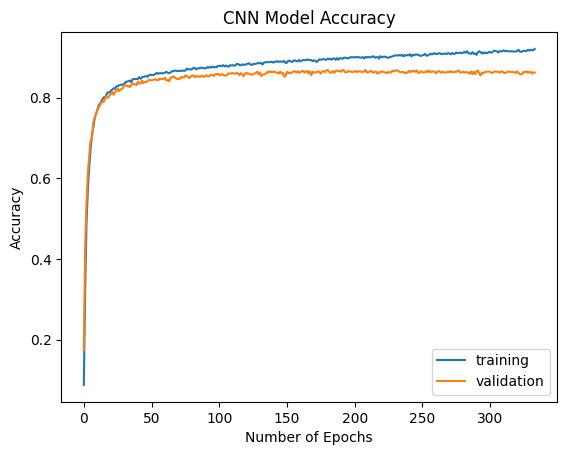

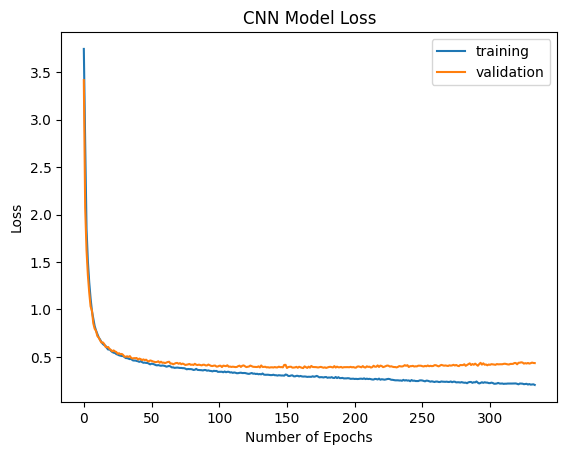

In [ ]:
# Plot training vs validation accruacy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# Plot training vs validation losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# 6- Evaluete model CNN model

In [ ]:
evaluate = model.evaluate(x_test, y_test)

# predict values for all data
predictions = model.predict(x_test)
print("predictions shape:", predictions.shape)

588/588 [==============================] - 4s 6ms/step
predictions shape: (18799, 47)


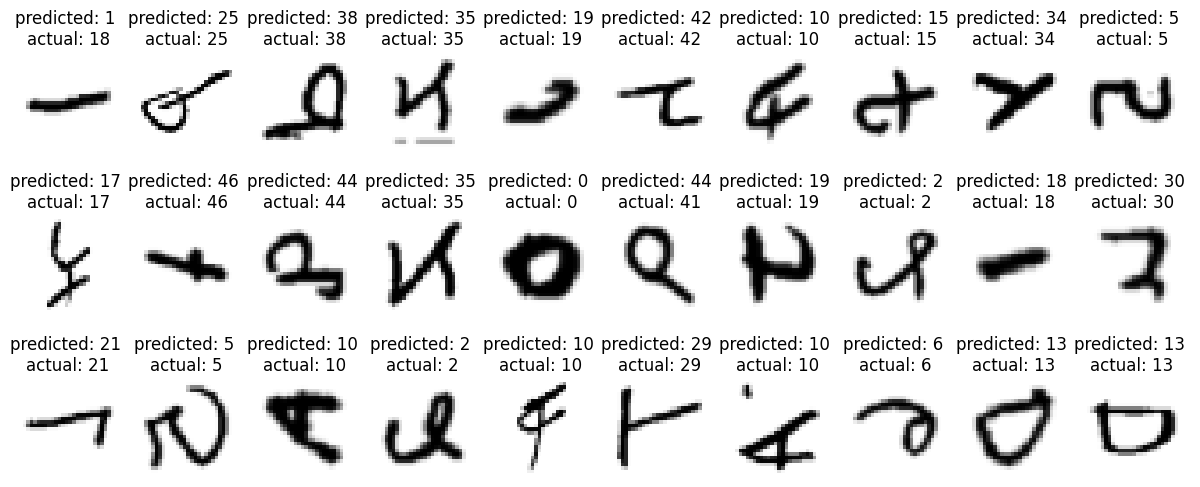

In [ ]:
# select random data from test set and predict it's classification
test_samples = random.sample(range(0, len(x_test)), 30) # select 30 samples

# display results
plt.figure(figsize=(15, 6))
for i in test_samples:
    plt.subplot(3, 10, test_samples.index(i) + 1)
    plt.imshow(x_test[i].reshape(28,28), cmap='binary')
    plt.title(f'predicted: {np.argmax(predictions[i])} \nactual: {y_test[i]}')
    plt.axis('off')

# 8- Algorithm K Nearest Neighbors - Bruteforce

In [ ]:
# model
model_0 = KNeighborsClassifier(n_neighbors = 3,
                             weights = "uniform",
                             algorithm = 'brute', # basic model
                             p = 2,
                             metric = "minkowski")

In [ ]:
# Fit/train model
def model_fit(model: KNeighborsClassifier, print_ = True):
  t1 = time.time()
  model.fit(x_train, y_train)
  t2 = time.time()
  if print_:
    print(f"Fit time: {t2 - t1}")
model_fit(model_0)

Fit time: 0.9501051902770996


In [ ]:
# Predict
def model_predict(model: KNeighborsClassifier, print_ = True):
  t1 = time.time()
  y_pred = model.predict(x_val)
  t2 = time.time()
  if print_:
    print(f"Predict time with X_val: {t2-t1}")
  return y_pred, t2-t1

y_pred, time_pred = model_predict(model_0)

Predict time with X_val: 123.84685778617859


In [ ]:
# Accuracy
def model_accuracy_(y_pred, print_ = True):
  accuracy = accuracy_score(y_val, y_pred)
  if print_:
    print(f"accuracy: {accuracy}")
  return accuracy

model_accuracy_(y_pred)

accuracy: 0.7730939716312056


0.7730939716312056

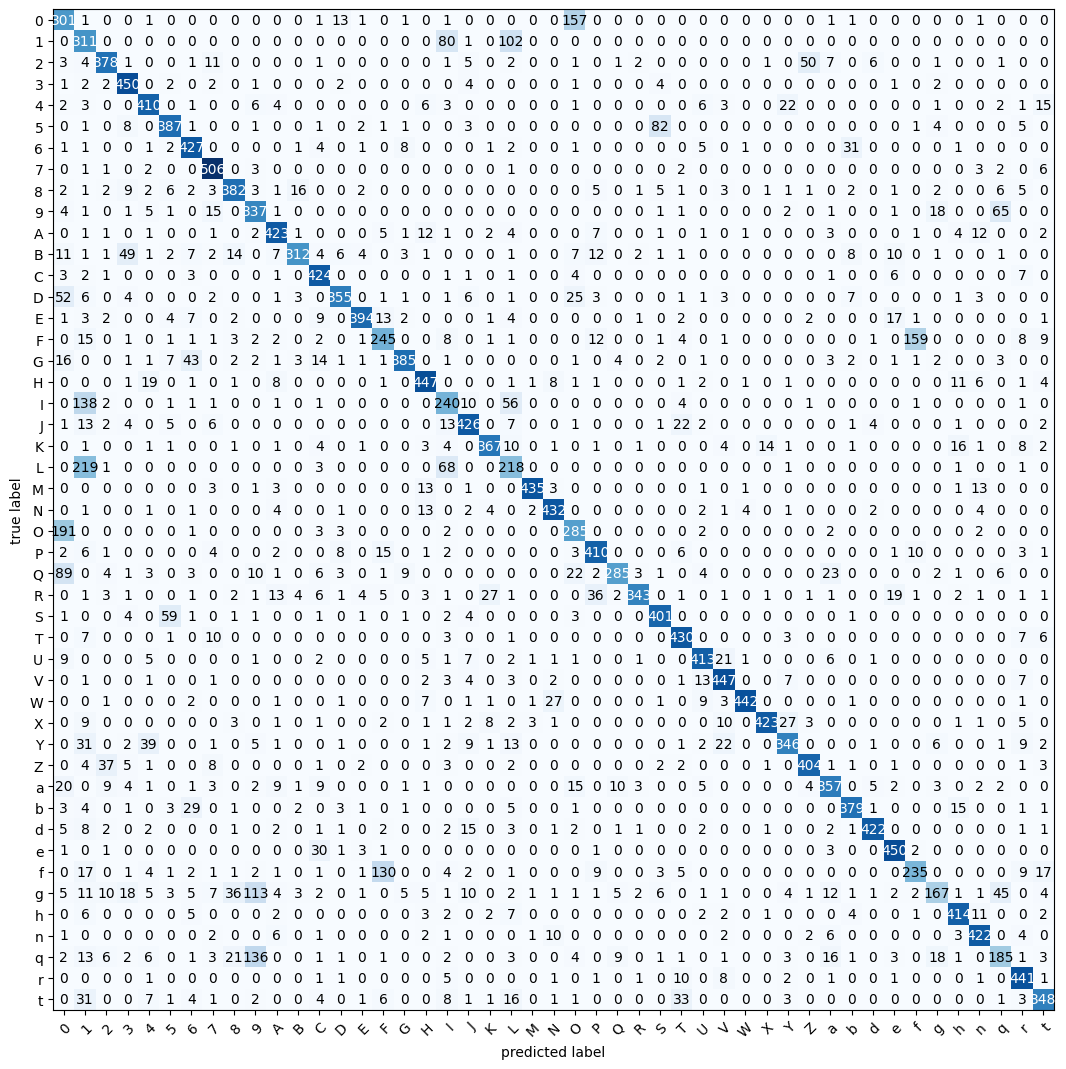

In [ ]:
# Plot confusion matrix
classes = [i for i in range(0,47)]
class_names = [by_merge_map[i] for i in classes]
def plot_confMatrix(y_pred):
  confMatrix = confusion_matrix(y_val, y_pred)
  plot_confusion_matrix(
    conf_mat=confMatrix, # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(13, 13)
    );

plot_confMatrix(y_pred)

## Tuning hyperparamters for basic kNN (bruteforce)

In [ ]:
list_n_neighbors = [20,30,40,50, 80,90,100]
list_weights = ["uniform", "distance"]

In [ ]:
list_models = []

for w in list_weights:
  for n in list_n_neighbors:
    newModel = KNeighborsClassifier(n_neighbors = n,
                                    weights = w,
                                    algorithm = 'brute')
    list_models.append(newModel)

print(f"Number of models to tune: {len(list_models)}\n")

Number of models to tune: 14



In [ ]:
# Predict models and Accuracy
list_of_time_pred =[]
list_of_acc = []

for i in range(len(list_models)):
  print(f"Start model {i} th")
  # 1. Fit/train model
  model_fit(list_models[i], print_ = False)

  # 2. predict model
  y_pred, time_pred = model_predict(list_models[i], print_ = False)

  # 3. Accuracy
  acc = model_accuracy_(y_pred, print_ = False)

  # Append
  list_of_time_pred.append(time_pred)
  list_of_acc.append(acc)
  print(f"Time_pred: {time_pred}")
  print(f"Accuracy: {acc}")
  print(f"End model {i} th\n")

print(f"list_of_time_pred:\n{list_of_time_pred}")
print(f"list_of_acc:\n{list_of_acc}")

Start model 0 th
Time_pred: 125.42745661735535
Accuracy: 0.7603723404255319
End model 0 th

Start model 1 th
Time_pred: 128.98918080329895
Accuracy: 0.7510638297872341
End model 1 th

Start model 2 th
Time_pred: 124.36318945884705
Accuracy: 0.7413120567375886
End model 2 th

Start model 3 th
Time_pred: 125.69764494895935
Accuracy: 0.732668439716312
End model 3 th

Start model 4 th
Time_pred: 126.00296640396118
Accuracy: 0.7160017730496454
End model 4 th

Start model 5 th
Time_pred: 126.1102569103241
Accuracy: 0.7112588652482269
End model 5 th

Start model 6 th
Time_pred: 126.11548924446106
Accuracy: 0.7070035460992907
End model 6 th

Start model 7 th
Time_pred: 123.13095808029175
Accuracy: 0.7651595744680851
End model 7 th

Start model 8 th
Time_pred: 124.71022033691406
Accuracy: 0.7545656028368795
End model 8 th

Start model 9 th
Time_pred: 123.31164288520813
Accuracy: 0.7454787234042554
End model 9 th

Start model 10 th
Time_pred: 121.10874915122986
Accuracy: 0.7374113475177305
End m

In [ ]:
# Plot the accuracy and choose the best model
idx_best_model = list_of_acc.index(max(list_of_acc))
print(f"The best model is the {idx_best_model} th model. Accuracy: {list_of_acc[idx_best_model]}")
print("Info")
print(list_models[idx_best_model].get_params())


The best model is the 7 th model. Accuracy: 0.7651595744680851
Info
{'algorithm': 'brute', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}


Predict time with X_val: 118.45011734962463
accuracy: 0.7651595744680851


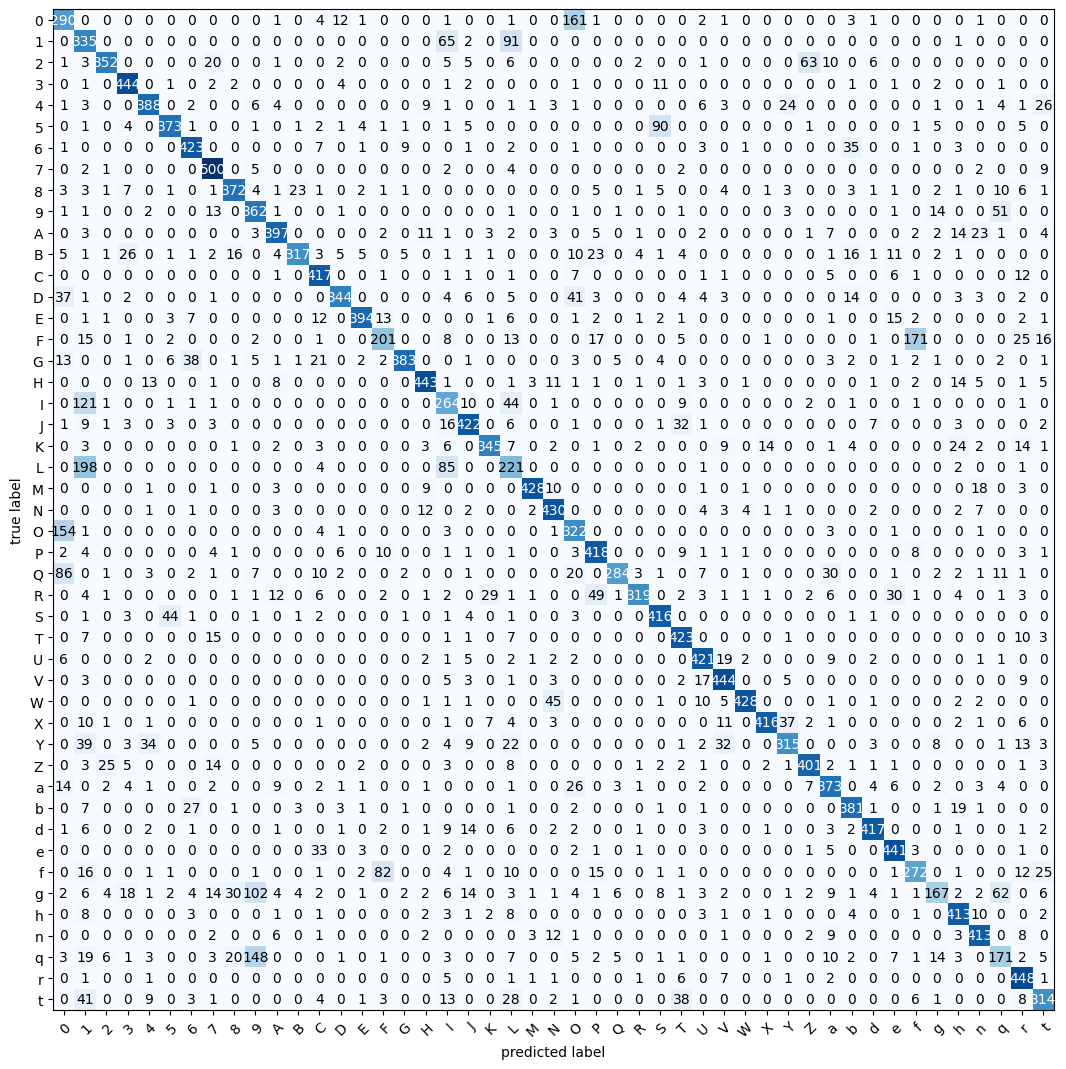

In [ ]:
# confusion matrix
best_model = list_models[idx_best_model]

# Predict model
y_pred, time_pred = model_predict(best_model)
acc = model_accuracy_(y_pred)
plot_confMatrix(y_pred)